In [ ]:
from docx import Document
import io
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# doc = Document("Doc1.docx")
# 
# for i, rel in enumerate(doc.part._rels):
#     if "image" in doc.part._rels[rel].target_ref:
#         image_data = doc.part._rels[rel]._target._blob
#         with open(f"image_{i}.png", "wb") as f:
#             f.write(image_data)

# Step 1: Load the image
img1_path = 'image_5.png'

In [ ]:
def extract_red_boundary(img1_path, min_points=80, min_width=100, min_height=100):
    img = cv2.imread(img1_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Detect red in HSV
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask = cv2.bitwise_or(
        cv2.inRange(hsv, lower_red1, upper_red1),
        cv2.inRange(hsv, lower_red2, upper_red2)
    )

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_contour = None
    max_score = 0

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if len(cnt) < min_points:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        if w < min_width or h < min_height:
            continue

        score = area * len(cnt)  # heuristic: large + complex
        if score > max_score:
            max_score = score
            best_contour = cnt

    return img, mask, best_contour

In [ ]:
img, mask, contours = extract_red_boundary(img1_path)

# Draw the contours on a copy of the original image
img_contours = img.copy()
cv2.drawContours(img_contours, contours, -1, (255, 0, 0), 2)


# Display the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Red Line Mask")
ax[2].imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
ax[2].set_title("Contours Detected")
plt.show()

In [ ]:
import cv2

def match_images(img1_path, img2_path):
    img1 = cv2.imread(img1_path, 0)
    img2 = cv2.imread(img2_path, 0)

    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    good_matches = [m for m in matches if m.distance < 40]
    print(f"Good match count: {len(good_matches)}")
    
    if len(good_matches) > 50:
        print("✅ Likely a strong match!")
    else:
        print("❌ Probably a weak match.")

    return len(matches), matches[:10]  # number of good matches and top 10



In [ ]:
img2_path = "image_6.PNG"

In [ ]:
match_images(img1_path, img2_path)

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load both images in **color**
img1 = cv2.imread("image_5.png")  # your subdivision screenshot
img2 = cv2.imread("image_6.png")  # map from portal

# Convert to grayscale for ORB detection
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detect ORB keypoints and descriptors
orb = cv2.ORB_create(5000)
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

# Match descriptors using Brute Force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance (lower is better)
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches — limit to best 20
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Top 20 ORB Matches")
plt.axis("off")
plt.show()


In [76]:
def tile_image(image, tile_size=(512, 512)):
    tiles = []
    img_h, img_w = image.shape[:2]
    for y in range(0, img_h, tile_size[1]):
        for x in range(0, img_w, tile_size[0]):
            tile = image[y:y+tile_size[1], x:x+tile_size[0]]
            if tile.shape[0] == tile_size[1] and tile.shape[1] == tile_size[0]:
                tiles.append(((x, y), tile))
    return tiles


In [77]:
def match_to_tiles(screenshot, map_image):
    orb = cv2.ORB_create(1000)
    gray_screenshot = cv2.cvtColor(screenshot, cv2.COLOR_BGR2GRAY)
    kp1, des1 = orb.detectAndCompute(gray_screenshot, None)

    tiles = tile_image(map_image)
    results = []

    for (x, y), tile in tiles:
        gray_tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
        kp2, des2 = orb.detectAndCompute(gray_tile, None)

        if des2 is None:
            continue

        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.match(des1, des2)
        good_matches = [m for m in matches if m.distance < 40]

        results.append(((x, y), len(good_matches)))

    return sorted(results, key=lambda x: -x[1])  # Sort descending by match score


In [82]:
screenshot = cv2.imread("screenshot.png")
map_image = cv2.imread("big_map.PNG")

results = match_to_tiles(screenshot, map_image)
best_tile_coords, match_count = results[0]
print(f"Best match at tile: {best_tile_coords} with {match_count} good matches")


Best match at tile: (512, 0) with 147 good matches


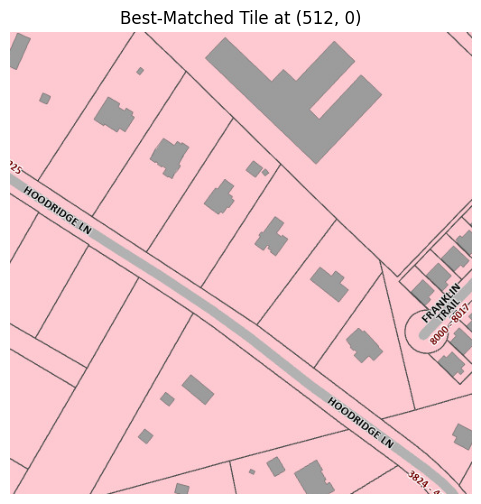

In [83]:
# Load full map image

# Best tile coordinates and size
tile_x, tile_y = 512, 0
tile_width, tile_height = 512, 512

# Crop the tile from the full image
matched_tile = map_image[tile_y:tile_y+tile_height, tile_x:tile_x+tile_width]

# Show it using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(matched_tile, cv2.COLOR_BGR2RGB))
plt.title(f"Best-Matched Tile at ({tile_x}, {tile_y})")
plt.axis("off")
plt.show()


Best match at tile: (512, 0) with 147 good matches


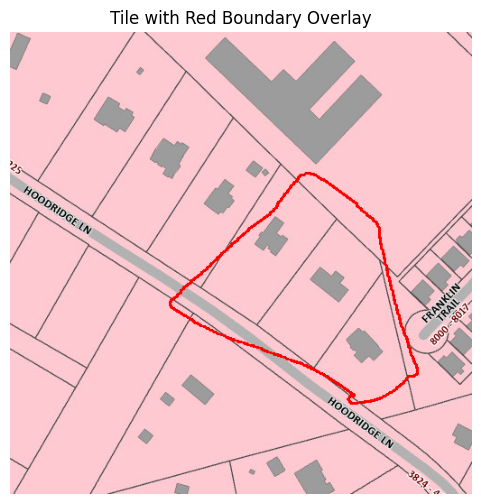

In [75]:
mport cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
screenshot_path = "screenshot.png"
map_image_path = "big_map.png"
tile_size = (512, 512)
# ----------------------------

# Step 1: Load images
screenshot = cv2.imread(screenshot_path)
map_image = cv2.imread(map_image_path)

# Step 2: Extract red boundary from screenshot
def extract_red_boundary(image, min_points=80, min_width=100, min_height=100):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    mask = cv2.bitwise_or(
        cv2.inRange(hsv, lower_red1, upper_red1),
        cv2.inRange(hsv, lower_red2, upper_red2)
    )
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best_contour = None
    max_score = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if len(cnt) < min_points:
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        if w < min_width or h < min_height:
            continue
        score = area * len(cnt)
        if score > max_score:
            max_score = score
            best_contour = cnt
    return best_contour

red_contour = extract_red_boundary(screenshot)

# Step 3: Tile the map
def tile_image(image, tile_size):
    tiles = []
    h, w = image.shape[:2]
    for y in range(0, h, tile_size[1]):
        for x in range(0, w, tile_size[0]):
            tile = image[y:y + tile_size[1], x:x + tile_size[0]]
            if tile.shape[:2] == tile_size[::-1]:
                tiles.append(((x, y), tile))
    return tiles

tiles = tile_image(map_image, tile_size)

# Step 4: Match screenshot to tiles using ORB
def match_to_tiles(screenshot, tiles):
    orb = cv2.ORB_create(1000)
    gray_screenshot = cv2.cvtColor(screenshot, cv2.COLOR_BGR2GRAY)
    kp1, des1 = orb.detectAndCompute(gray_screenshot, None)

    results = []
    for (x, y), tile in tiles:
        gray_tile = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
        kp2, des2 = orb.detectAndCompute(gray_tile, None)
        if des2 is None or des1 is None:
            continue
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.match(des1, des2)
        good = [m for m in matches if m.distance < 40]
        results.append(((x, y), len(good)))
    return sorted(results, key=lambda x: -x[1])

results = match_to_tiles(screenshot, tiles)
best_coords = results[0][0]
print(f"Best match at tile: {best_coords} with {results[0][1]} good matches")

# Step 5: Extract and display the best tile
tile_x, tile_y = best_coords
matched_tile = map_image[tile_y:tile_y + tile_size[1], tile_x:tile_x + tile_size[0]]

# Step 6: Resize screenshot + contour
def scale_contour(contour, orig_size, new_size):
    scale_x = new_size[0] / orig_size[0]
    scale_y = new_size[1] / orig_size[1]
    return np.array([[[int(pt[0][0] * scale_x), int(pt[0][1] * scale_y)]] for pt in contour])

screenshot_resized = cv2.resize(screenshot, tile_size)
scaled_contour = scale_contour(red_contour, screenshot.shape[1::-1], tile_size)

# Step 7: Draw contour on tile
tile_with_boundary = matched_tile.copy()
cv2.drawContours(tile_with_boundary, [scaled_contour], -1, (0, 0, 255), 2)  # red

# Step 8: Show result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(tile_with_boundary, cv2.COLOR_BGR2RGB))
plt.title("Tile with Red Boundary Overlay")
plt.axis("off")
plt.show()
